This code trains a deep learning model to identify consonants. It uses embeddings which are extract from embed_wav.ipynb.

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from glob import glob
from cv import RepeatedStratifiedGroupKFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import s3fs

In [11]:
# connect to s3
# must first enter AWS creds in cmd/terminal
s3 = s3fs.S3FileSystem()

In [12]:
consonant_list = ['b','p','k','g','m','n','t','d']  # other consonants excluded b/c of small sample size
NUM_CLASSES = len(consonant_list)  # 8 consonants
CONTEXT_SIZE = NUM_CLASSES * 2  # no of dims to extract from embeddings

In [61]:
def extract_data(main_df):
    """Extract embeddings (x) and consonant-labels (y)"""
    
    main_df = main_df[main_df['consonants'].isin(consonant_list)]
    vec_df = main_df.drop(columns='consonants')
    vec_arr = vec_df.to_numpy()

    vec_unravel_arr = np.zeros((1,16,1,96))  # shape req by model
    for arr in vec_arr:
        arr_unravel = arr.reshape(1,16,1,96)
        vec_unravel_arr = np.vstack((vec_unravel_arr, arr_unravel))
    
    # remove 3d row, which are zeros
    vec_unravel_arr = np.delete(vec_unravel_arr, 0, axis=0)
    
    con_arr = main_df['consonants'].to_numpy()
    
    x = vec_unravel_arr
    y = con_arr
    
    le = LabelEncoder()
    y_en = le.fit_transform(y)
    
    enc = {l: i for (i, l) in enumerate(le.fit(y).classes_)}

    return x, y_en, enc

In [14]:
org_df = pd.read_csv('embeddings_org_ravel.txt')  # unaltered data
aug_df = pd.read_csv('embeddings_aug_ravel.txt')  # augmented data
test_df = pd.read_csv('embeddings_test_ravel_phase2.txt')

In [15]:
all_df = pd.concat([org_df, aug_df], ignore_index=True)
all_df.shape

(5535, 1539)

In [16]:
# remove phase 2 samples
tfiles = s3.glob('s3://speech-first/data/01_raw/ah_consonants_ah/*/*.txt')
new_files = []
for f in tfiles:
    # phase 2 samples contain a metadata.txt file
    folder = f.replace("metadata.txt","")
    new_files_in_folder = s3.glob(f'{folder}/*.wav')
    new_files_in_folder = ['s3://' + x for x in new_files_in_folder]
    new_files.extend(new_ailes_in_folder)
    
all_df = all_df[~all_df['filepath'].isin(new_files)]
all_df.shape

(5359, 1539)

In [17]:
# create training data with equal num of consonants
con_max = all_df['consonants'].value_counts().max()
con_max_df = all_df.groupby("consonants").apply(lambda x: x.sample(n=con_max, replace=True))

In [62]:
x_train, y_train, enc = extract_data(con_max_df.iloc[:,:1537])
x_test, y_test, enc = extract_data(test_df.iloc[:,:1537])
# enc is the same in both cases

In [63]:
enc_reverse = {v: k for k, v in enc.items()}  # this will be handy later

Build multiple models using cross-validation. This makes the most use out of our relatively small dataset (<1000).

In [65]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(16,1,96)),
    layers.Conv2D(96, [3, 1], padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    layers.BatchNormalization(scale=True, trainable=False),
    layers.Dropout(0.2),
    layers.ELU(),
    layers.MaxPool2D((2, 1), strides=(2, 1), padding='valid'),
    layers.Conv2D(96, [3, 1], padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    layers.BatchNormalization(scale=True, trainable=False),
    layers.Dropout(0.2),
    layers.ELU(),
    layers.MaxPool2D((NUM_CLASSES, 1), padding='valid'),
    layers.Flatten(),
    layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
])

41/41 [==============================] - 0s 5ms/step - loss: 0.5833 - accuracy: 0.8940 - auc_18: 0.9791


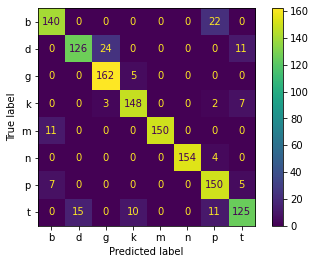

41/41 [==============================] - 0s 4ms/step - loss: 0.2751 - accuracy: 0.9384 - auc_19: 0.9882


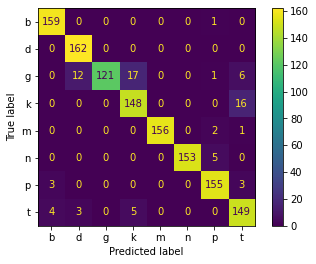

41/41 [==============================] - 0s 4ms/step - loss: 0.1136 - accuracy: 0.9690 - auc_20: 0.9979


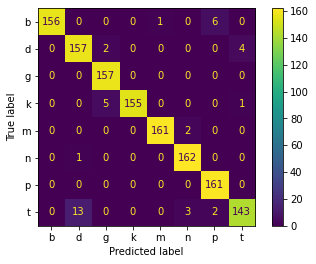

41/41 [==============================] - 0s 4ms/step - loss: 0.1421 - accuracy: 0.9690 - auc_21: 0.9964


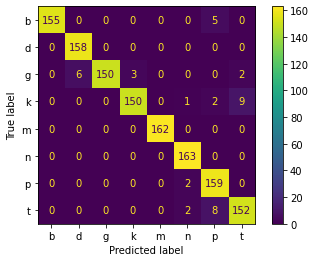

41/41 [==============================] - 0s 4ms/step - loss: 0.0787 - accuracy: 0.9799 - auc_22: 0.9998


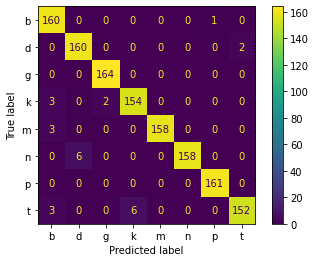

In [66]:
# split into train and test
# group samples from the same speaker in one group
# distribute consonants as equally as possible
cv = RepeatedStratifiedGroupKFold(n_splits=5, n_repeats=1, random_state=42)
groups = cv.split(X=x_train, y=y_train, groups=con_max_df['source_id'])
# source_id = unique speaker
# one speaker could have two or more source_id

for split_idx, (train_index, test_index) in enumerate(groups):
    x_train_grp, x_test_grp = x_train[train_index], x_train[test_index]
    y_train_grp, y_test_grp = y_train[train_index], y_train[test_index]
    
    y_train_grp_cat = tf.keras.utils.to_categorical(y_train_grp)
    y_test_grp_cat = tf.keras.utils.to_categorical(y_test_grp)
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["accuracy", tf.keras.metrics.AUC()])
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=3)
    model.fit(x_train_grp, y_train_grp_cat, epochs=100, verbose=0, callbacks=[callback], validation_data=(x_test_grp, y_test_grp_cat))
    model.evaluate(x_test_grp, y_test_grp_cat)
    
    # visualise data in confusion matrix
    y_preds = model.predict(x_test_grp)
    y_preds_sparse = y_preds.argmax(axis=1)
    y_test_sparse = y_test_grp_cat.argmax(axis=1)
    
    y_preds_sparse_str = [enc_reverse[x] for x in y_preds_sparse]
    y_test_sparse_str = [enc_reverse[x] for x in y_test_sparse]
    
    cm = confusion_matrix(y_test_sparse_str, y_preds_sparse_str, normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=enc.keys())
    disp.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal', values_format='.0f')
    plt.show()

Once you are happy with the validation accuracy and validation AUC metrics, you can build the model using all your data

In [67]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [68]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["accuracy", tf.keras.metrics.AUC()])

In [70]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=3)
model.fit(x_train, y_train_cat, epochs=100, verbose=1, callbacks=[callback], validation_data=(x_test, y_test_cat))

Epoch 1/100
202/202 [==============================] - 1s 7ms/step - loss: 0.0578 - accuracy: 0.9879 - auc_23: 0.9996 - val_loss: 1.0730 - val_accuracy: 0.8068 - val_auc_23: 0.9402
Epoch 2/100
202/202 [==============================] - 1s 7ms/step - loss: 0.0585 - accuracy: 0.9885 - auc_23: 0.9992 - val_loss: 1.1767 - val_accuracy: 0.7841 - val_auc_23: 0.9393
Epoch 3/100
202/202 [==============================] - 1s 7ms/step - loss: 0.1176 - accuracy: 0.9729 - auc_23: 0.9975 - val_loss: 1.0817 - val_accuracy: 0.7500 - val_auc_23: 0.9502
Epoch 4/100
202/202 [==============================] - 1s 7ms/step - loss: 0.0671 - accuracy: 0.9848 - auc_23: 0.9993 - val_loss: 1.3599 - val_accuracy: 0.8068 - val_auc_23: 0.9322


In [56]:
model.save('phoneme_convolutional_softmax')

INFO:tensorflow:Assets written to: phoneme_convolutional_softmax/assets
